DSCI 632

Summer 2022

Final Project: PySpark ML Student Performance

**Team: John Johnson, Katy Matulay, Justin Minnion**

In [ ]:
# Import Libraries for Databricks, note that PySpark is already pre-installed and instantiated
from pyspark.sql.functions import isnan, when, count, col, mean, udf, UserDefinedFunction
from pyspark.sql.types import StringType, IntegerType, DoubleType, FloatType

#graphics
import seaborn as sns
import matplotlib.pyplot as plt

#ML Libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

# Additional import and setup will be necessary to run this notebook outside of databricks

In [ ]:
#load dataset into DF1
df1 = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("dbfs:/FileStore/shared_uploads/km3868@drexel.edu/student_data.csv")

In [ ]:
df1.show(1,truncate= True)

+------+---+---+-------+-------+-------+----+----+-------+-------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|   Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+-------+-------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home|teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       6|  5|  6|  6|
+------+---+---+-------+-------+-------+----

In [ ]:
# view dataframe ~10 columns at a time
df1.select([this_col for this_col in df1.columns[:10]]).show(5)
df1.select([this_col for this_col in df1.columns[10:20]]).show(5)
df1.select([this_col for this_col in df1.columns[20:]]).show(5)

+------+---+---+-------+-------+-------+----+----+-------+--------+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|
+------+---+---+-------+-------+-------+----+----+-------+--------+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home| teacher|
|    GP|  F| 17|      U|    GT3|      T|   1|   1|at_home|   other|
|    GP|  F| 15|      U|    LE3|      T|   1|   1|at_home|   other|
|    GP|  F| 15|      U|    GT3|      T|   4|   2| health|services|
|    GP|  F| 16|      U|    GT3|      T|   3|   3|  other|   other|
+------+---+---+-------+-------+-------+----+----+-------+--------+
only showing top 5 rows

+------+--------+----------+---------+--------+---------+------+----+----------+-------+
|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|
+------+--------+----------+---------+--------+---------+------+----+----------+-------+
|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|
|course

##Data Prep

In [ ]:
#Convert G1, G2, G3 to binary for Pass/Fail  P = 1, F = 0
#Formula if G1||G2||G3 >= 10 --> P (1)  ELSE F (0)
grade_UDF = udf(lambda g: 1.0 if g >= 10 else 0.0, DoubleType())
#cols = ['G1','G2','G3']

df1_binaryG3 = df1.withColumn('G1_PF', grade_UDF(df1.G1)).withColumn('G2_PF', grade_UDF(df1.G2)).withColumn('G3_PF', grade_UDF(df1.G3))
df1_binaryG3.select('G1','G1_PF','G2','G2_PF','G3','G3_PF').show(3)

+---+-----+---+-----+---+-----+
| G1|G1_PF| G2|G2_PF| G3|G3_PF|
+---+-----+---+-----+---+-----+
|  5|  0.0|  6|  0.0|  6|  0.0|
|  5|  0.0|  5|  0.0|  6|  0.0|
|  7|  0.0|  8|  0.0| 10|  1.0|
+---+-----+---+-----+---+-----+
only showing top 3 rows



In [ ]:
#Examine if the dataset is balanced
df1_binaryG3.groupBy('G3_PF').count().show()

+-----+-----+
|G3_PF|count|
+-----+-----+
|  0.0|  130|
|  1.0|  265|
+-----+-----+



### Normalize Discrete Variables

In [ ]:
##normalize discrete variables  (needs done) *absences

avg_abs_array = df1_binaryG3.select(mean('absences')).first()
avg_abs = avg_abs_array[0]
print("Mean Absence",avg_abs)

#create broadcast variable to store avg absences
avg_abs_var = sc.broadcast(avg_abs)

#create UDF to normalize absences (subtract mean from absences)
normUDF = udf(lambda x: round(x- avg_abs_var.value,2), DoubleType())

#apply UDF to absences
df2 = df1_binaryG3.withColumn('absences_norm', normUDF(df1_binaryG3.absences))
df2.show(2)

Mean Absence 5.708860759493671
+------+---+---+-------+-------+-------+----+----+-------+-------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+-----+-----+-----+-------------+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|   Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|G1_PF|G2_PF|G3_PF|absences_norm|
+------+---+---+-------+-------+-------+----+----+-------+-------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+-----+-----+-----+-------------+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home|teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   

Out[50]: <AxesSubplot:xlabel='absences_norm'>

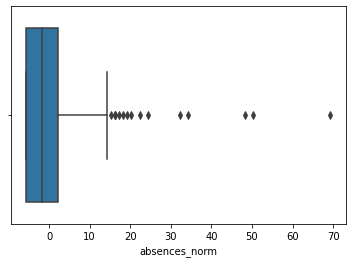

In [ ]:
#visualize absences distribution after normalization
abs_df = df2.select('absences_norm').toPandas()

#normalized distribution
sns.boxplot(x='absences_norm', data= abs_df)

In [ ]:
#Determine which columns are strings that need StringIndexer, which are Integer but categorical and need OneHotEncoder, and which can remain as integer
#df2.columns
df2.dtypes


Out[51]: [('school', 'string'),
 ('sex', 'string'),
 ('age', 'int'),
 ('address', 'string'),
 ('famsize', 'string'),
 ('Pstatus', 'string'),
 ('Medu', 'int'),
 ('Fedu', 'int'),
 ('Mjob', 'string'),
 ('Fjob', 'string'),
 ('reason', 'string'),
 ('guardian', 'string'),
 ('traveltime', 'int'),
 ('studytime', 'int'),
 ('failures', 'int'),
 ('schoolsup', 'string'),
 ('famsup', 'string'),
 ('paid', 'string'),
 ('activities', 'string'),
 ('nursery', 'string'),
 ('higher', 'string'),
 ('internet', 'string'),
 ('romantic', 'string'),
 ('famrel', 'int'),
 ('freetime', 'int'),
 ('goout', 'int'),
 ('Dalc', 'int'),
 ('Walc', 'int'),
 ('health', 'int'),
 ('absences', 'int'),
 ('G1', 'int'),
 ('G2', 'int'),
 ('G3', 'int'),
 ('G1_PF', 'double'),
 ('G2_PF', 'double'),
 ('G3_PF', 'double'),
 ('absences_norm', 'double')]

### Encoding Model 1 Parameters:
All Columns except G1, G2 to predict G3

In [ ]:
#TEST CASE CONVERTING ONE COLUMN STRINGINDEXER 
string_index = StringIndexer(inputCol='Mjob', outputCol='Mjob_index').fit(df2)
df2_test_index = string_index.transform(df2)
df2_test_index.select('Mjob','Mjob_index').show(4)

+-------+----------+
|   Mjob|Mjob_index|
+-------+----------+
|at_home|       2.0|
|at_home|       2.0|
|at_home|       2.0|
| health|       4.0|
+-------+----------+
only showing top 4 rows



In [ ]:
#TEST CASE CONVERTING ONE COLUMN ONEHOTENCODER 
OH_index = OneHotEncoder(inputCols=['Mjob_index'], outputCols = ["Mjob_num"]).fit(df2_test_index)
df2_test_index_OH = OH_index.transform(df2_test_index)
df2_test_index_OH.select('Mjob','Mjob_index','Mjob_num').show(2)

+-------+----------+-------------+
|   Mjob|Mjob_index|     Mjob_num|
+-------+----------+-------------+
|at_home|       2.0|(4,[2],[1.0])|
|at_home|       2.0|(4,[2],[1.0])|
+-------+----------+-------------+
only showing top 2 rows



In [ ]:
#convert string variables to binary Integers using StringIndexer and Pipeline
#STRING VARIABLES FOR STRING INDEXER
indexer_cols = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup',
                'famsup','paid','activities','nursery','higher','internet','romantic']

indexers = [StringIndexer(inputCol=col, outputCol = col+"_index").fit(df2) for col in indexer_cols]

pipeline = Pipeline(stages = indexers)
df2_transformed = pipeline.fit(df2).transform(df2)


In [ ]:
#validate that columns were transformed correctly
df2_transformed.select('school','school_index','sex','sex_index','Mjob','Mjob_index').show(4)


+------+------------+---+---------+-------+----------+
|school|school_index|sex|sex_index|   Mjob|Mjob_index|
+------+------------+---+---------+-------+----------+
|    GP|         0.0|  F|      0.0|at_home|       2.0|
|    GP|         0.0|  F|      0.0|at_home|       2.0|
|    GP|         0.0|  F|      0.0|at_home|       2.0|
|    GP|         0.0|  F|      0.0| health|       4.0|
+------+------------+---+---------+-------+----------+
only showing top 4 rows



In [ ]:
#COLUMN LISTS FOR ONEHOTENCODER AND FEATURE VECTOR
OH_cols = ['Medu','Fedu','Mjob_index','Fjob_index','reason_index','guardian_index','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health']

feature_cols = ['school_index',
 'sex_index',
 'address_index',
 'famsize_index',
 'Pstatus_index',
 'schoolsup_index',
 'famsup_index',
 'paid_index',
 'activities_index',
 'nursery_index',
 'higher_index',
 'internet_index',
 'romantic_index',
  'Medu_Num',
 'Fedu_Num',
 'Mjob_index_Num',
 'Fjob_index_Num',
 'reason_index_Num',
 'guardian_index_Num',
 'traveltime_Num',
 'studytime_Num',
 'failures_Num',
 'famrel_Num',
 'freetime_Num',
 'goout_Num',
 'Dalc_Num',
 'Walc_Num',
 'health_Num',
 'age',
 'absences']

print(len(feature_cols))

30


In [ ]:
#CATEGORICAL/ORDINAL VARIABLES FOR ONEHOTENCODER
encoders = [OneHotEncoder(inputCols = [col], outputCols = [col+"_Num"]).fit(df2_transformed) for col in OH_cols]

#Vector Assembler
encoders.append(VectorAssembler(inputCols=feature_cols, outputCol='features'))

#Assemble pipeline
pipeline = Pipeline(stages = encoders)
df3 = pipeline.fit(df2_transformed).transform(df2_transformed)

In [ ]:
#validate that features column has been assembled
df3.select('features').show(4, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------+
|(77,[4,5,6,8,11,23,27,29,32,36,40,42,49,53,59,61,66,73,75,76],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,6.0])|
|(77,[8,9,14,18,23,25,29,33,35,40,42,53,58,61,66,73,75,76],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,4.0])            |
|(77,[3,5,6,7,8,14,18,23,25,32,35,40,49,53,57,62,68,73,75,76],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,10.0])|
|(77,[7,12,19,26,30,32,35,41,42,48,52,57,61,66,75,76],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

In [ ]:
#validate conversions 
df3.select('traveltime_Num','traveltime','sex_index','guardian_index','guardian_index_num').show(2)

+--------------+----------+---------+--------------+------------------+
|traveltime_Num|traveltime|sex_index|guardian_index|guardian_index_num|
+--------------+----------+---------+--------------+------------------+
| (4,[2],[1.0])|         2|      0.0|           0.0|     (2,[0],[1.0])|
| (4,[1],[1.0])|         1|      0.0|           1.0|     (2,[1],[1.0])|
+--------------+----------+---------+--------------+------------------+
only showing top 2 rows



In [ ]:
df3.select('guardian_index','guardian_index_num','guardian').distinct().show()

+--------------+------------------+--------+
|guardian_index|guardian_index_num|guardian|
+--------------+------------------+--------+
|           2.0|         (2,[],[])|   other|
|           1.0|     (2,[1],[1.0])|  father|
|           0.0|     (2,[0],[1.0])|  mother|
+--------------+------------------+--------+



In [ ]:
#create featurized dataset for ML Model, G3_PF (Grade 3 pass/fail) is the label to predict
featurized_data = df3.select("G3_PF",'features').withColumnRenamed('G3_PF','label')
featurized_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(77,[4,5,6,8,11,2...|
|  0.0|(77,[8,9,14,18,23...|
|  1.0|(77,[3,5,6,7,8,14...|
|  1.0|(77,[7,12,19,26,3...|
|  1.0|(77,[7,8,11,16,20...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
#create the Test/Train datasets using 80/20 split
seed = 10
trainDF, testDF = featurized_data.randomSplit([0.8,0.2],seed)
print(trainDF.count(), testDF.count())

320 75


### Logistic Regression Cross Validation Model 1

In [ ]:
#Apply Logistic Regression Model to predict if Student will pass/fail G3

lr = LogisticRegression(maxIter = 10)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, np.linspace(0.3, 0.01, 10)) \
    .addGrid(lr.elasticNetParam, np.linspace(0.3, 0.8, 6)) \
    .build()
crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds= 5)  
cvModel_lr = crossval_lr.fit(trainDF)
best_model_lr = cvModel_lr.bestModel.summary


In [ ]:
#Train DF 
best_model_lr.predictions.show(5)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(77,[0,1,2,6,7,8,...|[-0.4798563177101...|[0.38228605428515...|       1.0|
|  0.0|(77,[0,1,2,6,8,11...|[-0.2211423955862...|[0.44493861174416...|       1.0|
|  0.0|(77,[0,1,2,6,9,12...|[-1.1342175107462...|[0.24338361429970...|       1.0|
|  0.0|(77,[0,1,2,8,14,1...|[0.24867223363157...|[0.56184966539444...|       0.0|
|  0.0|(77,[0,1,3,6,8,10...|[0.44410440728383...|[0.60923659309972...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### LR CV Model 1 Evaluation

In [ ]:
#Compute Accuracy for Train dataset
best_model_lr.predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  206|
|  0.0|       1.0|   73|
|  1.0|       0.0|   10|
|  0.0|       0.0|   31|
+-----+----------+-----+



In [ ]:
#Accuracy for Train  
total = 206+73+10+31
correct = 206+31
print('Train DF Accuracy:',(correct/total)*100,"%")

Train DF Accuracy: 74.0625 %


In [ ]:
#transform Test Data
predictions_lr = cvModel_lr.transform(testDF)
predictions_lr.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(77,[0,1,2,6,8,9,...|[0.01117903688206...|[0.50279473011559...|       0.0|
|  0.0|(77,[0,1,2,6,8,14...|[0.18176786021207...|[0.54531726185862...|       0.0|
|  0.0|(77,[0,1,3,4,7,8,...|[1.27090703233645...|[0.78089797735201...|       0.0|
|  0.0|(77,[0,2,6,14,19,...|[-0.9699900153401...|[0.27488249236915...|       1.0|
|  0.0|(77,[0,3,6,11,12,...|[0.47110059318903...|[0.61564421893612...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
#Calculate Accuracy using Binary/MulticlassMetrics

#convert to RDD tuples
pred_rdd_LR1 = predictions_lr.select('prediction','label').rdd.map(tuple)

metrics_LR1 = MulticlassMetrics(pred_rdd_LR1)
metrics_LR1B = BinaryClassificationMetrics(pred_rdd_LR1)

# Overall statistics
precision = metrics_LR1.precision(1.0)
recall = metrics_LR1.recall(1.0)
f1Score = metrics_LR1.fMeasure(1.0)
accuracy = metrics_LR1.accuracy
print("Summary Stats LR Model 1")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_LR1B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_LR1B.areaUnderROC)

Summary Stats LR Model 1
Accuracy =  69.33 %
Precision = 70.31 %
Recall =  91.84 %
F1 Score =  79.65 %
Area under PR = 0.70109268707483
Area under ROC = 0.5937990580847724


### Logistic Regression Cross Validation Model 2
(using reduced # features)

- Eliminated School, Mjob, Fjob, Dalc, Walc
- Added G1_PF, G2_PF (grade 1&2 converted to binary pass/fail)

In [ ]:
#cols to eliminate, per the research paper, adding in G1 & G2
remove_cols = ['Mjob','Fjob','Walc','Dalc','school']
reduced_feature_cols = [
 #'school_index',
 'sex_index',
 'address_index',
 'famsize_index',
 'Pstatus_index',
 'schoolsup_index',
 'famsup_index',
 'paid_index',
 'activities_index',
 'nursery_index',
 'higher_index',
 'internet_index',
 'romantic_index',
  'Medu_Num',
 'Fedu_Num',
 #'Mjob_index_Num',
 #'Fjob_index_Num',
 'reason_index_Num',
 'guardian_index_Num',
 'traveltime_Num',
 'studytime_Num',
 'failures_Num',
 'famrel_Num',
 'freetime_Num',
 'goout_Num',
# 'Dalc_Num',
# 'Walc_Num',
 'health_Num',
 'age',
 'absences',
 'G1_PF',  #added
 'G2_PF']  #added
len(reduced_feature_cols)

Out[69]: 27

In [ ]:
#CATEGORICAL/ORDINAL VARIABLES FOR ONEHOTENCODER
encoders2 = [OneHotEncoder(inputCols = [col], outputCols = [col+"_Num"]).fit(df2_transformed) for col in OH_cols]

#Build a new feature vector and df
#Vector Assembler
encoders2.append(VectorAssembler(inputCols=reduced_feature_cols, outputCol='features'))

#Assemble pipeline
pipeline = Pipeline(stages = encoders2)
df4 = pipeline.fit(df2_transformed).transform(df2_transformed)

In [ ]:
#create featurized dataset for ML Model, G3_PF (Grade 3 pass/fail) is the label to predict
featurized_data_reduced = df4.select("G3_PF",'features').withColumnRenamed('G3_PF','label')
featurized_data_reduced.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(60,[3,4,5,7,10,2...|
|  0.0|(60,[7,8,13,17,20...|
|  1.0|(60,[2,4,5,6,7,13...|
|  1.0|(60,[6,11,18,21,2...|
|  1.0|(60,[6,7,10,15,19...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
#create the Test/Train datasets using 80/20 split
seed = 10
trainDF2, testDF2 = featurized_data_reduced.randomSplit([0.8,0.2],seed)
print(trainDF2.count(), testDF2.count())

320 75


In [ ]:
#Apply Logistic Regression Model to predict if Student will pass/fail G3

lr2 = LogisticRegression(maxIter = 10)

paramGrid_lr2 = ParamGridBuilder() \
    .addGrid(lr2.regParam, np.linspace(0.3, 0.01, 10)) \
    .addGrid(lr2.elasticNetParam, np.linspace(0.3, 0.8, 6)) \
    .build()
crossval_lr2 = CrossValidator(estimator=lr2,
                          estimatorParamMaps=paramGrid_lr2,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds= 5)  
cvModel_lr2 = crossval_lr2.fit(trainDF2)
best_model_lr2 = cvModel_lr2.bestModel.summary

In [ ]:
#transform testDF
predictions_lr2 = cvModel_lr2.transform(testDF2)
predictions_lr2.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(60,[0,1,2,5,9,11...|[0.81593709981769...|[0.69337321921279...|       0.0|
|  0.0|(60,[0,1,4,5,6,10...|[-0.1354392827304...|[0.46619184435906...|       1.0|
|  0.0|(60,[0,1,5,7,8,10...|[0.05355707881031...|[0.51338607018240...|       0.0|
|  0.0|(60,[0,1,5,8,10,1...|[0.62956503899326...|[0.65239082956459...|       0.0|
|  0.0|(60,[0,1,7,10,11,...|[0.62904017884998...|[0.65227179381927...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### LR CV Model 2 Evaluation

In [ ]:
#Test DF Accuracy
predictions_lr2.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   46|
|  0.0|       1.0|    5|
|  1.0|       0.0|    3|
|  0.0|       0.0|   21|
+-----+----------+-----+



In [ ]:
#Calculate Accuracy using Binary/MulticlassMetrics

#convert to RDD tuples
pred_rdd_LR2 = predictions_lr2.select('prediction','label').rdd.map(tuple)

metrics_LR2 = MulticlassMetrics(pred_rdd_LR2)
metrics_LR2B = BinaryClassificationMetrics(pred_rdd_LR2)

# Overall statistics
precision = metrics_LR2.precision(1.0)
recall = metrics_LR2.recall(1.0)
f1Score = metrics_LR2.fMeasure(1.0)
accuracy = metrics_LR2.accuracy
print("Summary Stats LR CV Model 2")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_LR2B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_LR2B.areaUnderROC)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Summary Stats LR CV Model 2
Accuracy =  89.33 %
Precision = 90.2 %
Recall =  93.88 %
F1 Score =  92.0 %
Area under PR = 0.8943497398959585
Area under ROC = 0.8732339089481947


## Logistic Regression CV WT Model 2

In [ ]:
# Function to grab the ratio of true values
# Code adapted from http://blog.madhukaraphatak.com/spark-3-introduction-part-4
def get_ratio(df):
    fraudDf = df.filter("G3_PF=1.0")
    sampleRatio = fraudDf.count() / df.count()
    return sampleRatio

In [ ]:
#Apply Logistic Regression Model to predict if Student will pass/fail G3

# Feed in the data set, and save both values of when a student passes and when they dont. 
ratioOfFraud = get_ratio(df4)
passWeight  = 1 - ratioOfFraud
failWeight = ratioOfFraud

#Using a when/otherwise clause, when G3_PF is true then make the new column with the pass weight, otherwise put the fail weight. 
weightedDF = df4.withColumn("weight", when(df4.G3_PF == 1.0, passWeight).otherwise(failWeight))

#Select the new rdd containing weight. 
featurized_data_reduced = weightedDF.select("G3_PF",'features','weight').withColumnRenamed('G3_PF','label')

#create the Test/Train datasets using 80/20 split
seed = 10
weightedtrainDF2, weightedtestDF2 = featurized_data_reduced.randomSplit([0.8,0.2],seed)

In [ ]:
#Apply Logistic Regression Model to predict if Student will pass/fail G3

lr2 = LogisticRegression(maxIter = 10)
lr2.setWeightCol("weight")


paramGrid_lr2 = ParamGridBuilder() \
    .addGrid(lr2.regParam, np.linspace(0.3, 0.01, 10)) \
    .addGrid(lr2.elasticNetParam, np.linspace(0.3, 0.8, 6)) \
    .build()
crossval_lr2 = CrossValidator(estimator= lr2,
                          estimatorParamMaps=paramGrid_lr2,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds= 5)  
cvModel_lr2 = crossval_lr2.fit(weightedtrainDF2)
best_model_lr2 = cvModel_lr2.bestModel.summary


In [ ]:
prediction_lrModel = cvModel_lr2.transform(weightedtestDF2)

In [ ]:
#convert predictions df from test data to rdd
#prediction_RDD_lrModel = prediction_lrModel_summary.select('prediction','label').rdd.map(tuple)
prediction_RDD_lrModel = prediction_lrModel.select('prediction','label').rdd.map(tuple)

#instantiate multiclass and binaryclass metrics to obtain metrics
metrics_lrModel2 = MulticlassMetrics(prediction_RDD_lrModel)
metrics_lrModel2B = BinaryClassificationMetrics(prediction_RDD_lrModel)

# Overall statistics
precision = metrics_lrModel2.precision(1.0)
recall = metrics_lrModel2.recall(1.0)
f1Score = metrics_lrModel2.fMeasure(1.0)
accuracy = metrics_lrModel2.accuracy
print("Summary Stats LR CV WT Model 2")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_lrModel2B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_lrModel2B.areaUnderROC)

Summary Stats LR CV WT Model 2
Accuracy =  92.0 %
Precision = 95.74 %
Recall =  91.84 %
F1 Score =  93.75 %
Area under PR = 0.9450340136054423
Area under ROC = 0.9207221350078493


In [ ]:
#Generate ROC Curve 
# CODE ADAPTED FROM https://itecnote.com/tecnote/pyspark-extract-roc-curve/
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

Out[37]: [<matplotlib.lines.Line2D at 0x7f0a58929cd0>]

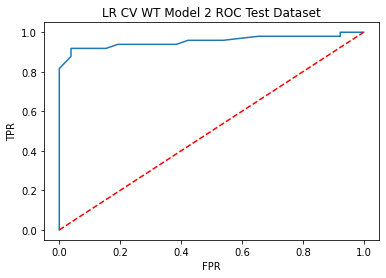

In [ ]:
# CODE ADAPTED FROM https://itecnote.com/tecnote/pyspark-extract-roc-curve/
# Returns as a list (false positive rate, true positive rate)
preds = prediction_lrModel.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('LR CV WT Model 2 ROC Test Dataset')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)
plt.plot([0, 1], [0, 1], 'r--')

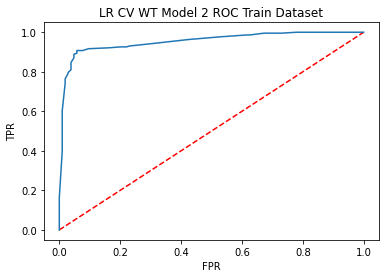

In [ ]:
#plotting the AUC/ROC
FPR = cvModel_lr2.bestModel.summary.roc.select('FPR').collect()    #train
TPR = cvModel_lr2.bestModel.summary.roc.select('TPR').collect()   #train

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LR CV WT Model 2 ROC Train Dataset')
plt.show()

In [ ]:
print(f"Multinomial coefficients:{cvModel_lr2.bestModel.coefficientMatrix }")
print(f"Multinomial intercept:{cvModel_lr2.bestModel.interceptVector}")

Multinomial coefficients:1 X 60 CSRMatrix
(0,33) 0.1653
(0,56) -0.002
(0,58) 0.7772
(0,59) 1.7984
Multinomial intercept:[-1.3587624453894471]


In [ ]:
summary = cvModel_lr2.bestModel.summary
print(summary)

### Logistic Regression Model 2 w/o Cross Validator

In [ ]:
#Logistic Regression Model 2 w/o Cross Validator
lr_model2 = LogisticRegression(
    maxIter=1000,
    featuresCol='features',
    labelCol='label'
    )
#fit model to train DF2
lrModel = lr_model2.fit(trainDF2)

#transform testDF2
prediction_lrModel = lrModel.transform(testDF2)


d
### LR Model 2 Evaluation

In [ ]:
prediction_RDD_lrModel = prediction_lrModel.select('prediction','label').rdd.map(tuple)

In [ ]:
#convert predictions df from test data to rdd
prediction_RDD_lrModel = prediction_lrModel.select('prediction','label').rdd.map(tuple)

#instantiate multiclass and binaryclass metrics to obtain metrics
metrics_lrModel2 = MulticlassMetrics(prediction_RDD_lrModel)
metrics_lrModel2B = BinaryClassificationMetrics(prediction_RDD_lrModel)

# Overall statistics
precision = metrics_lrModel2.precision(1.0)
recall = metrics_lrModel2.recall(1.0)
f1Score = metrics_lrModel2.fMeasure(1.0)
accuracy = metrics_lrModel2.accuracy
print("Summary Stats LR Model 2")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_lrModel2B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_lrModel2B.areaUnderROC)

Summary Stats LR Model 2
Accuracy =  73.33 %
Precision = 77.36 %
Recall =  83.67 %
F1 Score =  80.39 %
Area under PR = 0.7637684507765371
Area under ROC = 0.6875981161695447


In [ ]:
#len = 60  matches df4 features vector of length 60  which comes from reduced_feature_cols variable. There are only 27 columns in this variable though. 
print(f"Multinomial coefficients:{lrModel.coefficientMatrix}")
print(f"Multinomial intercepts:{lrModel.interceptVector}")

Multinomial coefficients:DenseMatrix([[-1.10364829e-01,  1.58845694e+00, -8.65222944e-01,
              -1.75912823e+00, -2.31607536e+00,  1.79377447e+00,
               2.30250109e+00,  1.62083084e+00,  2.25550142e+00,
               3.34547594e-01, -7.19016804e-02, -1.57191820e+00,
              -2.28451459e-01, -9.09916248e-01, -1.38534201e+00,
               5.92069150e-01,  6.43654451e+00,  1.99127772e+00,
              -1.47762514e-01, -1.12321860e+00, -2.92587332e-01,
               6.77547837e-01,  2.05613812e+00,  3.50909727e-01,
              -5.22458488e-01,  0.00000000e+00, -4.13216164e+00,
              -6.09540713e+00, -5.54216857e+00,  0.00000000e+00,
               5.10506846e+00,  3.28921180e+00,  2.39925150e+00,
               2.15017067e-01, -2.26590209e+00, -6.36574298e+00,
               0.00000000e+00, -2.91543841e+00, -9.54864733e-01,
              -1.01654080e+00, -9.22634615e-01,  0.00000000e+00,
               9.26469746e-01, -3.99369729e-03, -7.55982204e-01,


### Logistic Regression Model 2 with Class Weight

In [ ]:
#Apply Logistic Regression Model to predict if Student will pass/fail G3

# Feed in the data set, and save both values of when a student passes and when they dont. 
ratioOfFraud = get_ratio(df4)
passWeight  = 1 - ratioOfFraud
failWeight = ratioOfFraud

#Using a when/otherwise clause, when G3_PF is true then make the new column with the pass weight, otherwise put the fail weight. 
weightedDF = df4.withColumn("weight", when(df4.G3_PF == 1.0, passWeight).otherwise(failWeight))

#Select the new rdd containing weight. 
featurized_data_reduced = weightedDF.select("G3_PF",'features','weight').withColumnRenamed('G3_PF','label')

#create the Test/Train datasets using 80/20 split
seed = 10
weightedtrainDF2, weightedtestDF2 = featurized_data_reduced.randomSplit([0.8,0.2],seed)


#Create the weighted model 
lr_weighted = LogisticRegression(maxIter=1000,
    featuresCol='features',
    labelCol='label')

lr_weighted.setWeightCol("weight")

weightedcvModel_lr2 = lr_weighted.fit(weightedtrainDF2)



#transform testDF2
weighted_predictions_lr2 = weightedcvModel_lr2.transform(testDF2)

### Weighted LR Model 2 Evaluation

In [ ]:
#convert predictions df to RDD
prediction_RDD_lrModel = weighted_predictions_lr2.select('prediction','label').rdd.map(tuple)

#instantiate multiclass and binaryclass metrics to obtain metrics
metrics_lrModel2 = MulticlassMetrics(prediction_RDD_lrModel)
metrics_lrModel2B = BinaryClassificationMetrics(prediction_RDD_lrModel)

# Overall statistics
precision = metrics_lrModel2.precision(1.0)
recall = metrics_lrModel2.recall(1.0)
f1Score = metrics_lrModel2.fMeasure(1.0)
accuracy = metrics_lrModel2.accuracy
print("Summary Stats LR Weighted Model 2")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_lrModel2B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_lrModel2B.areaUnderROC)

Summary Stats LR Weighted Model 2
Accuracy =  73.33 %
Precision = 78.43 %
Recall =  81.63 %
F1 Score =  80.0 %
Area under PR = 0.7722849139655863
Area under ROC = 0.6966248037676609


Out[79]: [<matplotlib.lines.Line2D at 0x7f0a5d150220>]

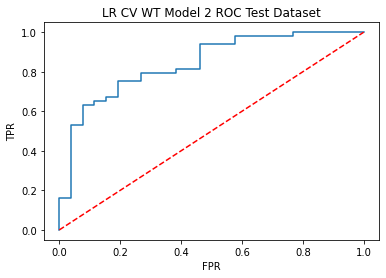

In [ ]:
# Generating the ROC Curve
# CODE ADAPTED FROM https://itecnote.com/tecnote/pyspark-extract-roc-curve/
# Returns as a list (false positive rate, true positive rate)
preds = weighted_predictions_lr2.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('LR CV WT Model 2 ROC Test Dataset')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)
plt.plot([0, 1], [0, 1], 'r--')

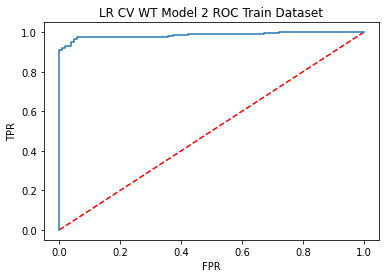

In [ ]:
#plotting the AUC/ROC for train
FPR =weightedcvModel_lr2.summary.roc.select('FPR').collect()    #train
TPR = weightedcvModel_lr2.summary.roc.select('TPR').collect()   #train

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LR CV WT Model 2 ROC Train Dataset')
plt.show()

In [ ]:
weightedcvModel_lr2.coefficientMatrix

Out[81]: DenseMatrix(1, 60, [0.0556, 1.4059, -0.8547, -2.2591, -2.3188, 2.2801, 2.3941, 2.019, ..., 0.863, 0.7324, 1.0353, -2.0674, -1.4314, 0.0811, 3.2234, 8.8292], 1)

## RandomForestClassifier Model 1

In [ ]:
#Using same TrainDF, TestDF from Logistic Regression Model 1

rf = RandomForestClassifier(featuresCol='features',labelCol='label')
rfModel = rf.fit(trainDF)

In [ ]:
#predict on Test data
pred_rf1 = rfModel.transform(testDF)
pred_rf1.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(77,[0,1,2,6,8,9,...|[10.8803583620045...|[0.54401791810022...|       0.0|
|  0.0|(77,[0,1,2,6,8,14...|[9.43498151255208...|[0.47174907562760...|       1.0|
|  0.0|(77,[0,1,3,4,7,8,...|[13.0950259989053...|[0.65475129994526...|       0.0|
|  0.0|(77,[0,2,6,14,19,...|[5.14576413256176...|[0.25728820662808...|       1.0|
|  0.0|(77,[0,3,6,11,12,...|[11.4856048166392...|[0.57428024083196...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



### RF Model 1 Evaluation

In [ ]:
#Calculate Accuracy using Binary/MulticlassMetrics

#convert to RDD tuples
pred_rdd_rf1 = pred_rf1.select('prediction','label').rdd.map(tuple)

metrics_RF1 = MulticlassMetrics(pred_rdd_rf1)
metrics_RF1B = BinaryClassificationMetrics(pred_rdd_rf1)

# Overall statistics
precision = metrics_RF1.precision(1.0)
recall = metrics_RF1.recall(1.0)
f1Score = metrics_RF1.fMeasure(1.0)
accuracy = metrics_RF1.accuracy
print("Summary Stats RF Model 1")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_RF1B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_RF1B.areaUnderROC)

Summary Stats RF Model 1
Accuracy =  69.33 %
Precision = 69.7 %
Recall =  93.88 %
F1 Score =  80.0 %
Area under PR = 0.6956338899196043
Area under ROC = 0.5847723704866562


## RandomForestClassifier Model 2
(reduced features from Logistic Regression Model 2)

In [ ]:
#Using same TrainDF, TestDF from Logistic Regression Model 2

rf2 = RandomForestClassifier(featuresCol='features',labelCol='label')
rfModel2 = rf2.fit(trainDF2)

In [ ]:
#predict on Test data
pred_rf2 = rfModel2.transform(testDF2)
pred_rf2.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(60,[0,1,2,5,9,11...|[15.7762637618727...|[0.78881318809363...|       0.0|
|  0.0|(60,[0,1,4,5,6,10...|[14.0723895154538...|[0.70361947577269...|       0.0|
|  0.0|(60,[0,1,5,7,8,10...|[9.11745490511564...|[0.45587274525578...|       1.0|
|  0.0|(60,[0,1,5,8,10,1...|[11.2788802529661...|[0.56394401264830...|       0.0|
|  0.0|(60,[0,1,7,10,11,...|[14.8874271091745...|[0.74437135545872...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



### RF Model 2 Evaluation

In [ ]:
#Calculate Accuracy using Binary/MulticlassMetrics

#convert to RDD tuples
pred_rdd_rf2 = pred_rf2.select('prediction','label').rdd.map(tuple)

metrics_RF2 = MulticlassMetrics(pred_rdd_rf2)
metrics_RF2B = BinaryClassificationMetrics(pred_rdd_rf2)

# Overall statistics
precision = metrics_RF2.precision(1.0)
recall = metrics_RF2.recall(1.0)
f1Score = metrics_RF2.fMeasure(1.0)
accuracy = metrics_RF2.accuracy
print("Summary Stats RF Model 1")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_RF2B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_RF2B.areaUnderROC)

Summary Stats RF Model 1
Accuracy =  88.0 %
Precision = 90.0 %
Recall =  91.84 %
F1 Score =  90.91 %
Area under PR = 0.8899319727891156
Area under ROC = 0.8630298273155417


## RandomForestClassifier  Weighted Model 2
(reduced features from Logistic Regression Model 2)

In [ ]:
#Using same TrainDF, TestDF from Logistic Regression Model 2

rf3 = RandomForestClassifier(featuresCol='features',labelCol='label')
rf3.setWeightCol("weight")
rfModel3 = rf3.fit(weightedtrainDF2)
pred_rf3 = rfModel3.transform(testDF2)

In [ ]:
#Calculate Accuracy using Binary/MulticlassMetrics

#convert to RDD tuples
pred_rdd_rf2 = pred_rf3.select('prediction','label').rdd.map(tuple)

metrics_RF2 = MulticlassMetrics(pred_rdd_rf2)
metrics_RF2B = BinaryClassificationMetrics(pred_rdd_rf2)

# Overall statistics
precision = metrics_RF2.precision(1.0)
recall = metrics_RF2.recall(1.0)
f1Score = metrics_RF2.fMeasure(1.0)
accuracy = metrics_RF2.accuracy
print("Summary Stats RF Weighted Model 2")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_RF2B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_RF2B.areaUnderROC)

Summary Stats RF Weighted Model 2
Accuracy =  90.67 %
Precision = 93.75 %
Recall =  91.84 %
F1 Score =  92.78 %
Area under PR = 0.9259013605442177
Area under ROC = 0.90149136577708


## Naive Bayes

### NB Model Implementation Model 1

In [ ]:
#create NB model using model 1 test/train DF
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nbmodel = nb.fit(trainDF)

pred3 = nbmodel.transform(testDF)

### NB Model 1 Evaluation

In [ ]:
#Calculate Accuracy using Binary/MulticlassMetrics

#convert to RDD tuples
pred_rdd_nb1 = pred3.select('prediction','label').rdd.map(tuple)

metrics_NB1 = MulticlassMetrics(pred_rdd_nb1)
metrics_NB1B = BinaryClassificationMetrics(pred_rdd_nb1)
#metrics.accuracy
#print("Naive Bayes Accuracy (Test) Data:", round(metrics3.accuracy*100,2),'%')

# Overall statistics
precision = metrics_NB1.precision(1.0)
recall = metrics_NB1.recall(1.0)
f1Score = metrics_NB1.fMeasure(1.0)
accuracy = metrics_NB1.accuracy
print("Summary Stats NB Model 1")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_NB1B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_NB1B.areaUnderROC)

Summary Stats NB Model 1
Accuracy =  68.0 %
Precision = 72.73 %
Recall =  81.63 %
F1 Score =  76.92 %
Area under PR = 0.7204823747680891
Area under ROC = 0.619701726844584


### NB Model 2 Implementation

In [ ]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nbmodel = nb.fit(trainDF2)

pred_nb2 = nbmodel.transform(testDF2)


### NB Model 2 Evaluation

In [ ]:
#Calculate Accuracy using Binary/MulticlassMetrics

#convert to RDD tuples
pred_rdd_nb2 = pred_nb2.select('prediction','label').rdd.map(tuple)

metrics_NB2 = MulticlassMetrics(pred_rdd_nb2)
metrics_NB2B = BinaryClassificationMetrics(pred_rdd_nb2)
#metrics.accuracy
#print("Naive Bayes Accuracy (Test) Data:", round(metrics3.accuracy*100,2),'%')

# Overall statistics
precision = metrics_NB2.precision(1.0)
recall = metrics_NB2.recall(1.0)
f1Score = metrics_NB2.fMeasure(1.0)
accuracy = metrics_NB2.accuracy
print("Summary Stats NB Model 2")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_NB2B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_NB2B.areaUnderROC)

Summary Stats NB Model 2
Accuracy =  84.0 %
Precision = 83.64 %
Recall =  93.88 %
F1 Score =  88.46 %
Area under PR = 0.830760667903525
Area under ROC = 0.7963108320251178


### NB Weighted Model 2 Implementation

In [ ]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb.setWeightCol("weight")
nbmodel = nb.fit(weightedtrainDF2)

pred_nb2 = nbmodel.transform(testDF2)

In [ ]:
#Calculate Accuracy using Binary/MulticlassMetrics

#convert to RDD tuples
pred_rdd_nb2 = pred_nb2.select('prediction','label').rdd.map(tuple)

metrics_NB2 = MulticlassMetrics(pred_rdd_nb2)
metrics_NB2B = BinaryClassificationMetrics(pred_rdd_nb2)
#metrics.accuracy
#print("Naive Bayes Accuracy (Test) Data:", round(metrics3.accuracy*100,2),'%')

# Overall statistics
precision = metrics_NB2.precision(1.0)
recall = metrics_NB2.recall(1.0)
f1Score = metrics_NB2.fMeasure(1.0)
accuracy = metrics_NB2.accuracy
print("Summary Stats NB Model 2")
print("Accuracy = ", round(accuracy*100,2),'%')
print("Precision =", round(precision*100,2),'%')
print("Recall = ", round(recall*100,2),'%')
print("F1 Score = ", round(f1Score*100,2),'%')

# Area under precision-recall curve
print("Area under PR = %s" % metrics_NB2B.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics_NB2B.areaUnderROC)

Summary Stats NB Model 2
Accuracy =  88.0 %
Precision = 88.46 %
Recall =  93.88 %
F1 Score =  91.09 %
Area under PR = 0.8775353218210361
Area under ROC = 0.8540031397174255
